In [63]:
import os
import csv
import mysql.connector as mc 
import time
import webbrowser
import sys
from sklearn.cluster import KMeans
%matplotlib inline
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, learning_curve
from sklearn.preprocessing import scale, PolynomialFeatures
sns.set()

In [47]:
cnx = mc.connect(user='akashgoyal',password=os.environ['DB_PASSWORD'],
                 host='stromberg.cs.uchicago.edu',database='mlb_practicum')

In [48]:
query = """SELECT Game.gameID AS gameID,abNum,pitchID,the_event,
                        firstBaseRunner,secondBaseRunner, thirdBaseRunner,outs,
                        home_team_runs,away_team_runs,curr_inn, homeTeamScore,
                        awayTeamScore,gameDate
                        FROM Pitch2 INNER JOIN Game ON Pitch2.gameID = Game.gameID
                        WHERE YEAR(gameDate)=2017""" #AND MONTH(gameDate)=4"""
df = pd.read_sql_query(query,cnx)

In [6]:
df.head()

,gameID,abNum,pitchID,the_event,firstBaseRunner,secondBaseRunner,thirdBaseRunner,outs,home_team_runs,away_team_runs,curr_inn,homeTeamScore,awayTeamScore,gameDate
0,ANA201704070,1,3,Walk,None,None,None,0,0,0,1.0,5,1,2017-04-07
1,ANA201704070,1,4,Walk,None,None,None,0,0,0,1.0,5,1,2017-04-07
2,ANA201704070,1,5,Walk,None,None,None,0,0,0,1.0,5,1,2017-04-07
3,ANA201704070,1,6,Walk,None,None,None,0,0,0,1.0,5,1,2017-04-07
4,ANA201704070,1,7,Walk,None,None,None,0,0,0,1.0,5,1,2017-04-07


In [49]:
#add a boolean column to determine if said team won.
df['win'] = pd.Series([(1 if (x[0]<x[1] and x[2]*2%2==0) or (x[0]>x[1] and x[2]*2%2==1) else 0)
                        for x in df[['homeTeamScore','awayTeamScore','curr_inn']].values])

#X = df[['abNum','pitchID',]]

In [67]:
class something:
    def __init__(self,cnx,year,month=4):
        query = """SELECT Game.gameID AS gameID,abNum,pitchID,the_event,
                        firstBaseRunner,secondBaseRunner, thirdBaseRunner,outs,
                        home_team_runs,away_team_runs,curr_inn, homeTeamScore,
                        awayTeamScore,gameDate
                        FROM Pitch2 INNER JOIN Game ON Pitch2.gameID = Game.gameID
                        WHERE YEAR(gameDate)='{}' AND MONTH(gameDate)='{}'""".format(year,month)
        self.df = pd.read_sql_query(query,cnx)
        self.get_lead_and_winloss()
    
    #add 2 columns saying what the lead (deficit) is and whether you won or lost
    def get_lead_and_winloss(self):
        self.df['win'] = pd.Series([(1 if (x[0]<x[1] and x[2]*2%2==0) or (x[0]>x[1] and x[2]*2%2==1) else 0)
                        for x in self.df[['homeTeamScore','awayTeamScore','curr_inn']].values])
        
        l = []
        for x in self.df[['home_team_runs','away_team_runs','curr_inn']].values:
            #if home team
            if x[2]*2%2==1:
                l.append(x[0]-x[1])
            else:
                l.append(x[1]-x[0])
        self.df['current_lead'] = pd.Series(l)
        return 

In [50]:
l = []
for x in df[['home_team_runs','away_team_runs','curr_inn']].values:
    #if home team
    if x[2]*2%2==1:
        l.append(x[0]-x[1])
    else:
        l.append(x[1]-x[0])
df['current_lead'] = pd.Series(l)
        

In [71]:
X = df[['current_lead','curr_inn','outs']]
Y = df['win']
interactions = PolynomialFeatures(degree=2)
X = interactions.fit_transform(X)


In [73]:
start = time.time()
logit = LogisticRegression(penalty='l1')
logit.fit(X,Y)
#sizes, train_scores, test_scores = learning_curve(logit,X,Y,cv=5,shuffle=True,
#                                                 train_sizes=np.linspace(0.1,1,10))
#print ('this took us {} seconds '.format(time.time()-start))
#print (sizes)
#print (train_scores)
#print (test_scores)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

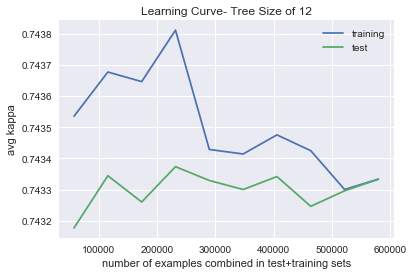

In [65]:
training_scores = []
testing_scores = []
for i,item in enumerate(train_scores):
	startScore = 0
	startScore2= 0
	for j in range(5):
		startScore+=train_scores[i][j]
		startScore2+=test_scores[i][j]

	training_scores.append(startScore/5)
	testing_scores.append(startScore2/5)

#now plot the validation curve
x_variable = sizes
plt.figure(2)
plt.plot(x_variable,training_scores,label='training')
plt.plot(x_variable,testing_scores,label='test')
plt.xlabel('number of examples combined in test+training sets')
plt.ylabel('avg kappa')
plt.title('Learning Curve- Tree Size of 12')
plt.legend()
plt.show()

In [59]:
logit = LogisticRegression(penalty='l1')
logit.fit(X,Y)
print(logit.score(X,Y))
logit = LogisticRegression(penalty='l2',max_iter=20)
logit.fit(X,Y)
print(logit.score(X,Y))

0.743342009169


In [69]:
X_a = a.df[['current_lead','curr_inn','outs']]
Y_a = a.df['win']
interactions_a = PolynomialFeatures(degree=2)
X_a = interactions_a.fit_transform(X_a)

In [74]:
logit.score(X_a,Y_a)

0.7417816974442667

,gameID,abNum,pitchID,the_event,firstBaseRunner,secondBaseRunner,thirdBaseRunner,outs,home_team_runs,away_team_runs,curr_inn,homeTeamScore,awayTeamScore,gameDate,win,current_lead
209,ANA201405020,59,469,Groundout,None,None,None,0,2,5,7.5,2,5,2014-05-02,0,-3.0
210,ANA201405020,59,470,Groundout,None,None,None,0,2,5,7.5,2,5,2014-05-02,0,-3.0
211,ANA201405020,59,471,Groundout,None,None,None,0,2,5,7.5,2,5,2014-05-02,0,-3.0
212,ANA201405020,59,472,Groundout,None,None,None,0,2,5,7.5,2,5,2014-05-02,0,-3.0
213,ANA201405020,59,473,Groundout,None,None,None,0,2,5,7.5,2,5,2014-05-02,0,-3.0


In [83]:
c = a.df[a.df['curr_inn']>9]
X_c = c[['current_lead','curr_inn','outs']]
Y_c = c['win']
interactions_c = PolynomialFeatures(degree=2)
X_c = interactions_c.fit_transform(X_c)
logit.score(X_c,Y_c)


0.75524673851389679